# Stanford CME 241 (Winter 2026) - Assignment 2

**Due: Friday, February 13 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/ward-benjamin/CME241_RL/blob/master/homeworks/assignment2.ipynb

*Group members (replace below names with people in your group):* 
- Benjamin Ward

## Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, log, lgamma 
from typing import Dict, List, Tuple, Mapping
from dataclasses import dataclass

In [19]:
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.distribution import Categorical
from scipy.stats import poisson
from rl.dynamic_programming import value_iteration_result, policy_iteration_result
from rl.markov_process import NonTerminal

## Question 1: Job-Hopping and Wages-Utility-Maximization (Led by Benjamin Ward)

You are a worker who starts every day either employed or unemployed. If you start your day employed, you work on your job for the day (one of $n$ jobs, as elaborated later) and you get to earn the wage of the job for the day. However, at the end of the day, you could lose your job with probability $\alpha \in [0,1]$, in which case you start the next day unemployed. If at the end of the day, you do not lose your job (with probability $1-\alpha$), then you will start the next day with the same job (and hence, the same daily wage). 

On the other hand, if you start your day unemployed, then you will be randomly offered one of $n$ jobs with daily wages $w_1, w_2, \ldots w_n \in \mathbb{R}^+$ with respective job-offer probabilities $p_1, p_2, \ldots p_n \in [0,1]$ (with $\sum_{i=1}^n p_i = 1$). You can choose to either accept or decline the offered job. If you accept the job offer, your day progresses exactly like the **employed-day** described above (earning the day's job wage and possibly (with probability $\alpha$) losing the job at the end of the day). However, if you decline the job offer, you spend the day unemployed, receive the unemployment wage $w_0 \in \mathbb{R}^+$ for the day, and start the next day unemployed.

The problem is to identify the optimal choice of accepting or rejecting any of the job offers the worker receives, in a manner that maximizes the infinite-horizon **Expected Discounted-Sum of Wages Utility**. Assume the daily discount factor for wages (employed or unemployed) is $\gamma \in [0,1])$. Assume Wages Utility function to be $U(w) = \log(w)$ for any wage amount $w \in \mathbb{R}^+$. The goal is to maximize:

$$
\mathbb{E}\left[\sum_{u=t}^\infty \gamma^{u-t} \cdot \log(w_{i_u})\right]
$$

at the start of a given day $t$ ($w_{i_u}$ is the wage earned on day $u$, $0 \leq i_u \leq n$ for all $u \geq t$).

---

### Subquestions

#### Part (A): MDP Modeling

Express the job-hopping problem as an MDP using clear mathematical notation by defining the following components:

1. **State Space**: Define the possible states of the MDP.
2. **Action Space**: Specify the actions available to the worker at each state.
3. **Transition Function**: Describe the probabilities of transitioning between states for each action.
4. **Reward Function**: Specify the reward associated with the states and transitions.
5. **Bellman Optimality Equation**: Write the Bellman Optimality Equation customized for this MDP.

---

#### Part (B): Python Implementation

Write Python code that:

1. Solves the Bellman Optimality Equation (hence, solves for the **Optimal Value Function** and the **Optimal Policy**) with a numerical iterative algorithm. 
2. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

*Note*: For this problem, write the algorithm from scratch without using any prebuilt MDP/DP libraries or code.

---

#### Part (C): Visualization and Analysis

1. Plot the **Optimal Value Function** as a function of the state for a specific set of parameters ($n$, $w_1, \ldots, w_n$, $p_1, \ldots, p_n$, $\alpha$, $\gamma$, $w_0$).
2. Include these graphs in your submission.

---

#### Part (D): Observations

1. What patterns do you observe in the **Optimal Policy** as you vary the parameters $n$, $\alpha$, and $\gamma$?
2. Provide a brief discussion of your findings.

---

### Part (A) Answer

1. **State Space**: 
- We define our "state" as our situation at the start of the day + the job offer if unemployed.
- At the start of each day, we are either start of day unempoyed with current job offer k ($U_k$) , or employed (at one of the n-jobs, for job k we note then $E_k$).
- So $S=\{U_1,...,U_n,E_1,...,E_n\}$.

2. **Action Space**: 
- If we are employed, we can only work, so $A(E_k)=\{\text{work}\}$.
- If we are unemployed, we observe offer for job $k$, then decide to accept or reject. So $A(U_k)=\{\text{accept},\text{reject}\}$.

3. **Transition Function**: 
- If we are employed at the start of the day, we lose it with probability $\alpha$ and become unemployed (with job offer $k$), or keep the same job with probability $1-\alpha$. So we have $\mathbb{P}[(E_k,\text{work})\rightarrow U_i]=\alpha p_i$ and $\mathbb{P}[(E_k\rightarrow E_k]=1-\alpha$.
- If we are unemployment at the start of the date (with offer $k$), we get: $\mathbb{P}((U_k,\text{accept})\rightarrow E_k)=1-\alpha$ and $\mathbb{P}((U_k,\text{accept})\rightarrow U_i)=\alpha p_i$.

4. **Reward Function**: 
- If we are employed at job $k$, we earn a wage $w_k$. The utility is $U(w)=\log(w)$. So $r(E_k,\text{work})=\log(w_k)$. 
- If we are unemployed with offer at job $k$, then $r(U_k,\text{accept})=\log(w_k)$ and $r(U_k,\text{rejected})=\log(w_0)$ (this is the unemployment wage).

5. **Bellman Optimality Equation**: 
- We note $\gamma\in[0,1]$ the discount factor. Then the Bellman Optimality Equation is given by (for a given state $U_k$ and $E_k$):
\begin{align}
V(E_k) &= \log(w_k)+\gamma((1-\alpha)V(E_k)+\sum_{i=1}^n\alpha p_iV(U_i)) \\
V(U_k) &= \max(\text{"if we accept"},\text{"if we reject"}) \\
&= \max(\log(w_k)+\gamma((1-\alpha)V(E_k)+\sum_{i=1}^n\alpha p_iV(U_i)),\log(w_0)+\gamma\sum_{i=1}^np_iV(U_i))
\end{align}

### Part (B) Answer

In [21]:
def solve_job_search_value_iteration(alpha: float,gamma: float,w0: float,
    wages: List[float],      # [w1, ..., wn]
    probs: List[float],      # [p1, ..., pn], sum to 1
    tol: float = 1e-10, max_iter: int = 10_000) -> Tuple[List[float], List[float], List[bool]]:
    
    n = len(wages)
    # Initialize values list for employed and unemployment (n length each)
    V_E = [0.0] * n
    V_U = [0.0] * n
    # Utility for each wage
    log_w0 = log(w0)
    log_w = [log(w) for w in wages]

    for q in range(max_iter):
        # Expected value of unemployed before received offer
        EU = sum(p * v for p, v in zip(probs, V_U))
        # Store value function updates
        new_V_E = [0.0] * n
        new_V_U = [0.0] * n
        # Update employed states
        for i in range(n):
            new_V_E[i] = log_w[i] + gamma * ((1.0 - alpha) * V_E[i] + alpha * EU)
        # Update unemployed states
        for i in range(n):
            accept_val = log_w[i] + gamma * ((1.0 - alpha) * V_E[i] + alpha * EU)
            reject_val = log_w0 + gamma * EU
            new_V_U[i] = max(accept_val, reject_val)
        # Convergence
        diff = 0.0
        for i in range(n):
            diff = max(diff, abs(new_V_E[i] - V_E[i]), abs(new_V_U[i] - V_U[i]))
        V_E, V_U = new_V_E, new_V_U
        if diff < tol:
            break

    # Extract the optimal accept/reject policy in each U_i
    EU = sum(p * v for p, v in zip(probs, V_U))
    accept = []
    for i in range(n):
        accept_val = log_w[i] + gamma * ((1.0 - alpha) * V_E[i] + alpha * EU)
        reject_val = log_w0 + gamma * EU
        accept.append(accept_val >= reject_val)

    return V_E, V_U, accept

In [22]:
alpha = 0.2
gamma = 0.95
w0 = 50.0
wages = [40.0, 60.0, 90.0]
probs = [0.3, 0.5, 0.2]

V_E, V_U, accept = solve_job_search_value_iteration(alpha, gamma, w0, wages, probs)

print("V(E_i):", V_E)
print("V(U_i):", V_U)
print("Accept offers?:", accept)  # True/False per offer i

V(E_i): [82.05897193934968, 83.74840988980041, 85.43784784025108]
V(U_i): [83.93839206243953, 83.93839206243953, 85.43784784025108]
Accept offers?: [False, False, True]


### Part (C) Answer

In [16]:
def plot_value_function(alpha: float, gamma: float, w0: float, wages: list[float],probs: list[float]):
    # Step 1: solve MDP
    V_E, V_U, accept = solve_job_search_value_iteration(alpha=alpha,gamma=gamma,w0=w0,wages=wages,probs=probs)
    n = len(wages)
    # States labels and values
    states = [f"E{i+1}" for i in range(n)] + [f"U{i+1}" for i in range(n)]
    values = V_E + V_U
    # Plots
    plt.figure()
    plt.bar(range(len(values)), values)
    plt.xticks(range(len(values)), states)
    plt.xlabel("State")
    plt.ylabel("Optimal Value V*(state)")
    plt.title("Optimal Value Function across States")
    plt.tight_layout()
    plt.show()

In [25]:
def plot_value_function(alpha: float, gamma: float, w0: float, wages: List[float], probs: List[float]) -> None:
    V_E, V_U, accept = solve_job_search_value_iteration(alpha, gamma, w0, wages, probs)
    # Plot value vs wage
    plt.figure()
    plt.plot(wages, V_E, marker="o", label="V*(E_i): employed at wage w_i")
    plt.plot(wages, V_U, marker="o", label="V*(U_i): unemployed w/ offer w_i")
    # Annotate accept/reject decisions at U_i
    for w, vu, a in zip(wages, V_U, accept):
        plt.annotate("A" if a else "R", (w, vu), textcoords="offset points", xytext=(0, 8), ha="center")
    plt.axvline(w0, linestyle="--", label="Unemployment wage w0")
    plt.xlabel("Offered/Job wage w_i")
    plt.ylabel("Optimal value V*")
    plt.title("Optimal Value Function vs Wage (with Accept/Reject annotations)")
    plt.legend()
    plt.tight_layout()
    plt.show()

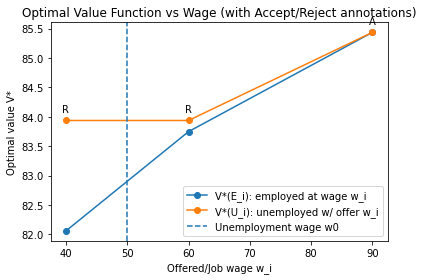

In [26]:
alpha = 0.2
gamma = 0.95
w0 = 50.0
wages = [40.0, 60.0, 90.0]
probs = [0.3, 0.5, 0.2]

plot_value_function(alpha, gamma, w0, wages, probs)

### Part (D) Answer

Patterns observed when we vary $n$, $\alpha$ and $\gamma$:
- Varying $n$: n is the number of different jobs. I did not find any clear monotonous pattern solely dependent on $n$. It seems like we add lots of "lower-quality" jobs, then we increase the likelihood of accepting the original set of jobs. But if we add lots of "higher-quality" jobs, then we decrease the likelihood of accepting the original set of jobs.
- Varying $\alpha$: if we decrease $\alpha$, we decrease the job loss probability. We find that as $\alpha$ decreases, we accept more offers, since there is there benefit of a "very likely" continued income stream from that job (even if the pay is not that high). On the opposite, it $\alpha$ is high, there is no longer this benefit of a continue income stream from a "mediocre" job, so we are more to sit out and wait for a much better job.
- Varying $\gamma$: $\gamma$ is the discount factor, so when we decrease it, we increase the relative importance of short term cash flows vs. longer term cash flows. We find that as we decrease $\gamma$, we tend to accept more offers because we just want to secure any wage increase (vs. the unemployment baseline). When $\gamma$ increases, we're not "stressed" to get cash flow immediately, so we are happier to wait it out for a better offer and therefore we reject more offers.

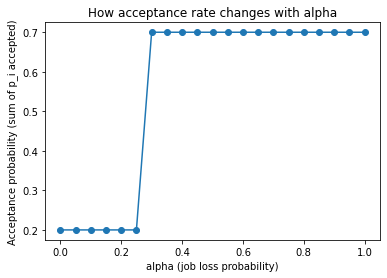

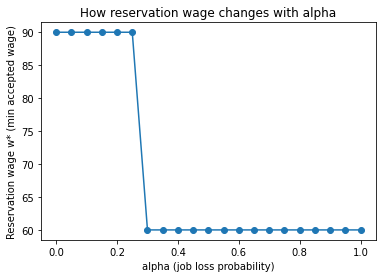

In [31]:
def acceptance_stats(accept: List[bool], wages: List[float], probs: List[float]):
    acc_prob = sum(p for a, p in zip(accept, probs) if a)
    accepted_wages = [w for a, w in zip(accept, wages) if a]
    w_star = min(accepted_wages) if accepted_wages else None
    return acc_prob, w_star

def sweep_alpha(alphas, gamma, w0, wages, probs):
    acc_probs = []
    w_stars = []
    for a in alphas:
        V_E, V_U, accept = solve_job_search_value_iteration(a, gamma, w0, wages, probs)
        acc_prob, w_star = acceptance_stats(accept, wages, probs)
        acc_probs.append(acc_prob)
        w_stars.append(w_star if w_star is not None else float("nan"))
    return acc_probs, w_stars

alphas = [i/20 for i in range(0, 21)]  # 0.00, 0.05, ..., 1.00
gamma = 0.95
w0 = 50.0
wages = [40.0, 60.0, 90.0]
probs = [0.3, 0.5, 0.2]

acc_probs, w_stars = sweep_alpha(alphas, gamma, w0, wages, probs)

plt.figure()
plt.plot(alphas, acc_probs, marker="o")
plt.xlabel("alpha (job loss probability)")
plt.ylabel("Acceptance probability (sum of p_i accepted)")
plt.title("How acceptance rate changes with alpha")
plt.show()

plt.figure()
plt.plot(alphas, w_stars, marker="o")
plt.xlabel("alpha (job loss probability)")
plt.ylabel("Reservation wage w* (min accepted wage)")
plt.title("How reservation wage changes with alpha")
plt.show()

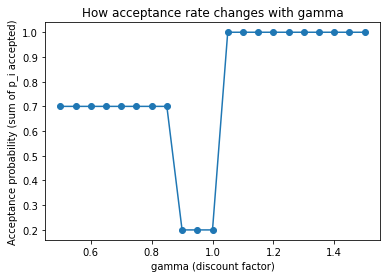

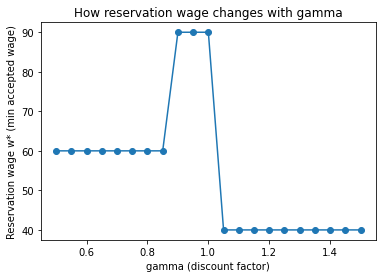

In [32]:
def sweep_gamma(gammas, alpha, w0, wages, probs):
    acc_probs = []
    w_stars = []
    for g in gammas:
        V_E, V_U, accept = solve_job_search_value_iteration(alpha, g, w0, wages, probs)
        acc_prob, w_star = acceptance_stats(accept, wages, probs)
        acc_probs.append(acc_prob)
        w_stars.append(w_star if w_star is not None else float("nan"))
    return acc_probs, w_stars

gammas = [0.50 + i*0.05 for i in range(21)]  # 0.50..0.95, 1
alpha = 0.2
acc_probs_g, w_stars_g = sweep_gamma(gammas, alpha, w0, wages, probs)

plt.figure()
plt.plot(gammas, acc_probs_g, marker="o")
plt.xlabel("gamma (discount factor)")
plt.ylabel("Acceptance probability (sum of p_i accepted)")
plt.title("How acceptance rate changes with gamma")
plt.show()

plt.figure()
plt.plot(gammas, w_stars_g, marker="o")
plt.xlabel("gamma (discount factor)")
plt.ylabel("Reservation wage w* (min accepted wage)")
plt.title("How reservation wage changes with gamma")
plt.show()

## Question 2: Two-Stores Inventory Control (Led by Benjamin Ward)

We extend the capacity-constrained inventory example implemented in [rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py) as a `FiniteMarkovDecisionProcess` (the Finite MDP model for the capacity-constrained inventory example is described in detail in Chapters 1 and 2 of the RLForFinanceBook). Here we assume that we have two different stores, each with their own separate capacities $C_1$ and $C_2$, their own separate Poisson probability distributions of demand (with means $\lambda_1$ and $\lambda_2$), their own separate holding costs $h_1$ and $h_2$, and their own separate stockout costs $p_1$ and $p_2$. At 6pm upon stores closing each evening, each store can choose to order inventory from a common supplier (as usual, ordered inventory will arrive at the store 36 hours later). We are also allowed to transfer inventory from one store to another, and any such transfer happens overnight, i.e., will arrive by 6am next morning (since the stores are fairly close to each other). Note that the orders are constrained such that following the orders on each evening, each store's inventory position (sum of on-hand inventory and on-order inventory) cannot exceed the store's capacity (this means the action space is constrained to be finite). Each order made to the supplier incurs a fixed transportation cost of $K_1$ (fixed-cost means the cost is the same no matter how many units of non-zero inventory a particular store orders). Moving any non-zero inventory between the two stores incurs a fixed transportation cost of $K_2$. 

Model this as a derived class of `FiniteMarkovDecisionProcess` much like we did for `SimpleInventoryMDPCap` in the code repo. Set up instances of this derived class for different choices of the problem parameters (capacities, costs etc.), and determine the Optimal Value Function and Optimal Policy by invoking the function `value_iteration` (or `policy_iteration`) from file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py).

Analyze the obtained Optimal Policy and verify that it makes intuitive sense as a function of the problem parameters.

Analysis of the obtained optimal policy: I ran different experiments with different parameter values to test out some effects. Here is what I found:

- In this problem we have a fixed order cost $K_1$ (transportation). We would expect then to only order when the stock is low enough (below a threshold which is inversely proportional to $K_1$ maybe). If we increase $K_1$, we make orders less frequent but larger. 

- In this problem, we can transfer by have to pay a fixed cost $K_2$ (transportation). We would expect then to one transfer if only store has lots of inventory and the other one is really low, especially if the low store has high expected demand (or stock penalty). Else it's not worth it. If we increase $K_2$ we make transfer more "expensive", and thus only when there is a risk of paying a big penalty if we don't transfer.

- As demand rate $\lambda_i$ increases, the store tends to order more aggresively. As the penalty $p_i$ increases, the store tends to order more aggresively because it's really bad to miss demand. As the holding costs increase, the store tends to order less aggresively because of the holding cost. There is a subtle balance between the penalty $p_i$ and the holding cost $h_i$.

- If we decrease capacity, we are forced to do more frequent ordering and transfering decisions, which could lead to stockout penalties.

In [33]:
@dataclass(frozen=True)
class TwoStoreInventoryState:
    # Evening state after demand is realized for the day:
    # on_hand_i = inventory physically on-hand at store i at evening
    # on_order_i = inventory already ordered earlier that will arrive overnight
    on_hand_1: int
    on_order_1: int
    on_hand_2: int
    on_order_2: int

    def ip1(self) -> int:
        return self.on_hand_1 + self.on_order_1

    def ip2(self) -> int:
        return self.on_hand_2 + self.on_order_2

# Action = (order1, order2, transfer)
# If transfer > 0: move units from store 1 to store 2 (happens overnight)
# If transfer < 0: move units from store 2 to store 1 (happens overnight)
Action = Tuple[int, int, int]

TwoStoreMap = Mapping[TwoStoreInventoryState, Mapping[Action, Categorical[Tuple[TwoStoreInventoryState, float]]]]


class TwoStoreInventoryMDPCap(FiniteMarkovDecisionProcess[TwoStoreInventoryState, Action]):
    '''
    # C1, C2: max inventory per store
    # lambda1, lambda2: Poisson demand lambdas 
    # h1, h2: holdings costs per unit if excess inventory
    # p1, p2: stockout costs per unit of unmet demand
    # K1, K2: fixed supplier order cost per store (only if order > 0), fixed transfer cost (only if transfer not 0)
    '''

    def __init__(self,C1: int,C2: int,lambda1: float,lambda2: float,h1: float,h2: float,p1: float,p2: float,K1: float,K2: float):
        self.C1, self.C2 = C1, C2
        self.lambda1, self.lambda2 = lambda1, lambda2
        self.h1, self.h2 = h1, h2
        self.p1, self.p2 = p1, p2
        self.K1, self.K2 = K1, K2
        self.po1, self.po2 = poisson(lambda1), poisson(lambda2)
        # Call the construction from Finite Markov Decision Process
        super().__init__(self.get_action_transition_reward_map())

    @staticmethod
    def _tail_prob_and_conditional_shortage(po, s: int):
        """
        tail = P(D >= s)
        cond_shortage = E[D - s | D >= s]
        """
        tail = 1.0 - po.cdf(s - 1) if s > 0 else 1.0
        if tail == 0.0:
            return 0.0, 0.0
        lam = po.mean()
        tail_prev = 1.0 - po.cdf(s - 2) if s > 1 else 1.0
        cond_shortage = lam * tail_prev / tail - s
        return tail, max(0.0, cond_shortage)

    def get_action_transition_reward_map(self) -> TwoStoreMap:
        d: Dict[TwoStoreInventoryState, Dict[Action, Categorical[Tuple[TwoStoreInventoryState, float]]]] = {}
        # All feasible evening states where each store inventory position <= capacity
        for a1 in range(self.C1 + 1):
            for b1 in range(self.C1 + 1 - a1):
                for a2 in range(self.C2 + 1):
                    for b2 in range(self.C2 + 1 - a2):
                        s = TwoStoreInventoryState(a1, b1, a2, b2)
                        # For this state, build all feasible actions and their outcome distributions
                        action_map: Dict[Action, Categorical[Tuple[TwoStoreInventoryState, float]]] = {}
                        # Transfer τ is limited by current on-hand at the SOURCE store
                        # τ in [-a2, a1]
                        for tau in range(-a2, a1 + 1):
                            # Apply transfer overnight to on-hand inventories
                            tpos = tau if tau > 0 else 0
                            tneg = -tau if tau < 0 else 0
                            # Update
                            a1_after = a1 - tpos + tneg
                            a2_after = a2 + tpos - tneg
                            # After transfer, existing on_order arrives overnight before next-day demand
                            start1 = a1_after + b1
                            start2 = a2_after + b2
                            # Capacity constraint (after evening)
                            # Inventory position after ordering: a1_after + b1
                            max_o1 = self.C1 - (a1_after + b1)
                            max_o2 = self.C2 - (a2_after + b2)

                            for o1 in range(max_o1 + 1):
                                for o2 in range(max_o2 + 1):
                                    action: Action = (o1, o2, tau)
                                    # Fixed costs (apply regardless of demand realization)
                                    fixed_cost = 0.0
                                    if o1 > 0: 
                                        fixed_cost -= self.K1
                                    if o2 > 0: 
                                        fixed_cost -= self.K1
                                    if tau != 0:
                                        fixed_cost -= self.K2
                                    # For each store, we create a finite set of “demand outcomes”:
                                    # Calculate P(D>= start) and expected shortage conditioned on tail
                                    tail1, cond_short1 = self._tail_prob_and_conditional_shortage(self.po1, start1)
                                    tail2, cond_short2 = self._tail_prob_and_conditional_shortage(self.po2, start2)
                                    # Build outcome tables per store: list of (ending_on_hand, stockout_cost, prob)
                                    outcomes1 = []
                                    for k in range(start1):
                                        pk = float(self.po1.pmf(k))
                                        end1 = start1 - k
                                        outcomes1.append((end1, 0.0, pk))
                                    if tail1 > 0:
                                        outcomes1.append((0, self.p1 * cond_short1, tail1))

                                    outcomes2 = []
                                    for k in range(start2):
                                        pk = float(self.po2.pmf(k))
                                        end2 = start2 - k
                                        outcomes2.append((end2, 0.0, pk))
                                    if tail2 > 0:
                                        outcomes2.append((0, self.p2 * cond_short2, tail2))
                                    # Combine the two stores (independent demands)
                                    sr_probs: Dict[Tuple[TwoStoreInventoryState, float], float] = {}
                                    # Base reward
                                    base_reward = fixed_cost - self.h1 * a1_after - self.h2 * a2_after
                                    for end1, so_cost1, prob1 in outcomes1:
                                        for end2, so_cost2, prob2 in outcomes2:
                                            prob = prob1 * prob2
                                            next_state = TwoStoreInventoryState(on_hand_1=end1,on_order_1=o1,on_hand_2=end2,on_order_2=o2)
                                            # Reward = negative costs
                                            stockout_cost = so_cost1 + so_cost2
                                            reward = base_reward - stockout_cost

                                            sr_probs[(next_state, reward)] = sr_probs.get((next_state, reward), 0.0) + prob
                                    action_map[action] = Categorical(sr_probs)
                        d[s] = action_map
        return d

In [42]:
gamma = 0.95
mdp = TwoStoreInventoryMDPCap(
    C1=3, C2=3,
    lambda1=1.0, lambda2=2.0,
    h1=1.0, h2=1.0,
    p1=10.0, p2=10.0,
    K1=2.0, K2 = 1.0
)
opt_vf, opt_policy = value_iteration_result(mdp, gamma=gamma)
# opt_vf, opt_policy = policy_iteration_result(mdp, gamma=gamma)
print(opt_policy)

For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=0, on_order_2=0): Do Action (3, 3, 0)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=0, on_order_2=1): Do Action (3, 2, 0)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=0, on_order_2=2): Do Action (3, 1, 0)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=0, on_order_2=3): Do Action (3, 0, 0)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=1, on_order_2=0): Do Action (3, 2, 0)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=1, on_order_2=1): Do Action (2, 2, -1)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=1, on_order_2=2): Do Action (2, 1, -1)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=2, on_order_2=0): Do Action (2, 2, -1)
For State TwoStoreInventoryState(on_hand_1=0, on_order_1=0, on_hand_2=2, on_order_2=1): Do Action (2, 1, -1)
For State TwoStoreInvent

Interpretation of results:

## Question 3: Dynamic Price Optimization (Led by Benjamin Ward)

You own a supermarket, and you are $T$ days away from Halloween 🎃. You have just received $M$ Halloween masks from your supplier. You want to dynamically set the selling price of the Halloween masks at the start of each day in a manner that maximizes your **Expected Total Sales Revenue** for Halloween masks this season (assume no one will buy Halloween masks after Halloween).

Assume that for each of the $T$ days, you are required to select a price for that day from one of $N$ prices $p_1, p_2, \dots, p_N \in \mathbb{R}$, and that price is the selling price for all masks on that day. Assume that the customer demand for the number of Halloween masks on any day is governed by a Poisson probability distribution with mean $\lambda_i \in \mathbb{R}$ if you select that day’s price to be $p_i$ (where $i$ is a choice among $1, 2, \dots, N$).

Note that on any given day, the demand could exceed the number of Halloween masks you have in the store, in which case the number of masks sold on that day will be equal to the number of Halloween masks you had at the start of that day.

We spoke about this example in class - referencing the slides here (if needed) could be helpful!

---

### Subquestions

#### Part (A): Bellman Optimality Equation

Write the **Bellman Optimality Equation** customized to this Markov Decision Process (MDP). Essentially, you need to express the **Optimal Value Function** $v_*$ recursively based on taking the best action in the current state and based on the subsequent random customer demand that would produce the appropriate reward and take you to the next state.

**Note**: The probability mass function of a Poisson distribution with mean $\lambda \in \mathbb{R}$ is given by:

$$
f(k) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

---

#### Part (B): Boundary Conditions

To be able to solve the $v_*$ recursion, you need to know the values of $v_*$ for the boundary case (boundary states). Write down the boundary case(s) for the $v_*$ recursion.

---

#### Part (C): Numerical Solution

You can solve this $v_*$ recursion (hence, solve for the **Optimal Policy** $\pi_*$) with a numerical recursive algorithm (essentially a special form of Dynamic Programming algorithm customized to this problem). 

Write Python code for this algorithm that would enable you to dynamically set the selling price at the start of each day. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

---


### Part (A) Answer

Let's clarify some things first. Originally we have M Halloween masks. Without loss of generality, at day t, we note $m$ the amount of Halloween masks left. We want to determine $v_t(m)$ which is the maximum expected revenue from days t to T, given that we have $m$ units left at start of day t. The actions correspond to the choice of a price in $\{p_1,...,p_n\}$. Once we choose a price, then demand $d_t\sim \text{Poisson}(\lambda_i)$. So the amount of masks we actually sell on that day is $\min(d_t,m)$ (we can't sell more masks than we have). Our revenue for that day is therefore $p_i\min(d_t,m)$, and we will have $m-\min(d_t,m)$ masks leftover for the next day.

So the Bellman Optimality Equation can be written for all $t=1,...,T$ as (where the expectation is taken over $d_t\sim \text{Poisson}(\lambda_i)$):
\begin{align}
v_t(m)&=\max_{i\in\{1,...,N\}}\mathbb{E}[p_i\min(d_t,m)+v_{t+1}(m-min(d_t,m))] \\
&=\max_{i\in\{1,...,N\}}\sum_{k=1}^{\infty}\frac{e^{-\lambda_i}\lambda_i^k}{k!}[p_i\min(k,m)+v_{t+1}(m-min(k,m))]
\end{align}

### Part (B) Answer

We have 2 boundary cases. First time is that if we have no more inventory in Halloween masks (i.e. $m=0$) then we can't do anything so $v_t(0)=0$ for all $t$. Additionally, we assume that no one will buy Halloween masks after Halloween, so $v_{T+1}(m)=0$ for all $m$.

### Part (C) Answer

To clarify our algorithm below: we use backward induction and the Bellman equation we proved previously. Our function "solve_dp" takes in m (initial inventory of Halloween masks), T (number of time steps), prices (a list of floats) and lambdas (a list of floats). It outputs the optimal value function v[t][k] which represents the optimal value function at a time t when we have k inventory left) and the optimal policy p[t][k] which represents the best price choice at time t and with k inventory left).

In [20]:
# fill in with Python code
def poisson_prob(k:int, lam:float) -> float:
    # Return P(X=k) for X following Poisson(lam)
    return exp(-lam+k*log(lam)-lgamma(k+1))

def poisson_tail(m:int, lam:float) -> float:
    # Return P(X>=m)
    cdf = 0
    for k in range(m):
        cdf += poisson_prob(k,lam)
    res = 1-cdf
    return res

def solve_dp(T: int, M:int, prices: List[float], lambdas: List[float]) -> Tuple[List[List[float]], List[List[int]]]:
    # Return v_t(m) and policy_t(m)
    N = len(prices)
    V = [[0.0]*(M+1) for _ in range(T+2)] # we need t=0,...,T+1 (last for boundary)
    policy = [[0]*(M+1) for _ in range(T+1)] # we need t=0,...,T
    # Backward induction
    for t in range(T,0,-1):
        for m in range(1,M+1):
            best_val = float('-inf')
            best_i = 0
            for i in range(N):
                p = prices[i]
                lam = lambdas[i]
                # Use Bellman equation E[p*min(d,m)+V_t+1(m-min(d,m))]
                val = 0
                for k in range(m):
                    pk = poisson_prob(k,lam)
                    val += pk*(p*k+V[t+1][m-k])
                tail = poisson_tail(m,lam)
                val += tail*(p*m+V[t+1][0]) # boundary here is used v_t+1(0)=0

                if val > best_val:
                    best_val = val 
                    best_i = i 
                
            V[t][m] = best_val
            policy[t][m] = best_i 
    
    return V, policy

## Question 4: Risk-Aversion and Utility Optimization under CARA Utility (Led by Benjamin Ward)

You are tasked with analyzing the behavior of an investor who seeks to maximize their utility under **CARA Utility**. The investor has wealth $W$ and the CARA utility function:

$$
U(W) = \frac{1 - e^{-aW}}{a}, \quad a > 0,
$$

where $a$ represents the investor's **risk aversion**.

The investor allocates their wealth between:
1. A **riskless asset** with a fixed return $r$, and
2. A **risky asset** with return $R \sim \mathcal{N}(\mu, \sigma^2)$

The investor allocates a fraction $\pi$ of their wealth to the risky asset and $(1 - \pi)$ to the riskless asset. The wealth $W$ after one year is given by:

$$
W = (1 + r)(1 - \pi) + (1 + R)\pi.
$$

The goal is to analyze the investor’s optimal allocation $\pi$ to the risky asset and compute key risk-related quantities.

---

### Subquestions

#### Part (A): Expected Utility and Certainty-Equivalent Wealth

1. Derive the expression for the **expected utility** $\mathbb{E}[U(W)]$, using the given CARA utility function and assuming $R \sim \mathcal{N}(\mu, \sigma^2)$.
2. Using a Taylor expansion, approximate the **certainty-equivalent wealth** $W_{CE}$ up to second-order terms.

---

#### Part (B): Optimal Portfolio Allocation

Derive the optimal fraction $\pi^*$ of wealth to be allocated to the risky asset such that the **expected utility** $\mathbb{E}[U(W)]$ is maximized. Express $\pi^*$ in terms of $a$, $\mu$, $r$, and $\sigma^2$.

---

#### Part (C): Risk Premium

1. Using the results from Part (A), calculate the **absolute risk premium** $\pi_A = \mathbb{E}[W] - W_{CE}$.
2. Verify that $\pi_A \approx \frac{a \pi^2 \sigma^2}{2}$ for small $\sigma^2$.

---

#### Part (D): Numerical Calculations and Interpretation

Given the parameters $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$:
1. Compute the optimal allocation $\pi^*$.
2. Calculate the certainty-equivalent wealth $W_{CE}$.
3. Compute the absolute risk premium $\pi_A$.
4. Interpret the results and discuss how changes in $a$ and $\sigma^2$ affect the risk premium and portfolio allocation.

---

#### Part (E): Expected Utility under Uniform Distribution

Now assume that the return of the risky asset, $R$, is no longer normally distributed. Instead, $R \sim \text{Uniform}[\alpha, \beta]$, where $\alpha$ and $\beta$ are the lower and upper bounds of the distribution, respectively.

1. Derive the new expression for the **expected utility** $\mathbb{E}[U(W)]$. Make sure to simplify your result as much as possible, and ensure that it explicitly depends on $a$, $\pi$, $\alpha$, $\beta$, and $r$.

**Hint**: Use the fact that if $W \sim \text{Uniform}[w_{\text{min}}, w_{\text{max}}]$, then:

$$
\mathbb{E}[g(W)] = \frac{1}{w_{\text{max}} - w_{\text{min}}} \int_{w_{\text{min}}}^{w_{\text{max}}} g(W) \, dW.
$$

---

### Part (A) Answer
We have: $R\sim \mathcal{N}(\mu,\sigma^2)$ and $W=(1+r)(1-\pi)+(1+R)\pi$.

So $W\sim \mathcal{N}(\mu_W,\sigma^2_W)$ where $\mu_W=(1+r)(1-\pi)+(1+\mu)\pi$ and $\sigma_W^2=\pi^2\sigma^2$.

Then $\mathbb{E}[U(W)]=\mathbb{E}[\frac{1-\exp(-aW)}{a}]=\frac{1}{a}-\frac{1}{a}\mathbb{E}[\exp(-aW)]$. 

We recognise that this is very close to the moment generating function of $W\sim\mathcal{N}(\mu_W,\sigma_W^2)$, which is given by:
\begin{align}
\mathbb{E}[\exp(tW)]=\exp(t\mu_W+\frac{1}{2}t^2\sigma_W^2)
\end{align}
Plugging in $t=-a$, we get:
\begin{align}
\mathbb{E}[U(W)] &= \frac{1}{a}-\frac{1}{a}\exp(-a\mu_W+\frac{1}{2}a^2\sigma_W^2) \\
&= \frac{1}{a}-\frac{1}{a}\exp(-a[(1+r)(1-\pi)+(1+\mu)\pi]+\frac{1}{2}a^2\pi^2\sigma^2) \\
&= \frac{1}{a}-\frac{1}{a}\exp(-a[(1+r)+\pi(\mu-r)]+\frac{1}{2}a^2\pi^2\sigma^2)
\end{align}
Let's now use a second-order Taylor expansion to approximate $W_{CE}$, defined by $U(W_{CE})=\mathbb{E}[U(W)]$.

We use 2 Taylor expansions. First the first-order $U(W_{CE})\approx U(\mu)+U'(\mu)(W_{CE}-\mu)$, then the second-order $\mathbb{E}[U(W)]\approx U(\mathbb{E}[W])+\frac{1}{2}U''(\mathbb{E}[W])\text{Var}(W)$.

Plugging in using $U(W)=\frac{1-\exp(-aW)}{a}$, this gives: $U'(W)=\exp(-aW)$ and $U''(W)=-a\exp(-aW)$, with $\text{Var}(W)=\sigma_W^2$, we can combine the 2 Taylor expansions:
\begin{align}
U(W_{CE})&\approx \mathbb{E}[U(W)] \\
\Rightarrow U(\mu)+U'(\mu)(W_{CE}-\mu) &\approx U(\mathbb{E}[W])+\frac{1}{2}U''(\mathbb{E}[W])\text{Var}(W) \\
\Rightarrow U(\mu)+\exp(-a\mu)(W_{CE}-\mu) &\approx U(\mu)-\frac{a\exp(-a\mu)}{2}\sigma_W^2 \\
\Rightarrow W_{CE} &\approx \mu -\frac{a\sigma_W^2}{2} \\
\Rightarrow W_{CE} &\approx (1+r)+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}
\end{align}

### Part (B) Answer

We previously showed that $\mathbb{E}[U(W)]=\frac{1}{a}-\frac{1}{a}\exp(-a[(1+r)+\pi(\mu-r)]+\frac{1}{2}a^2\pi^2\sigma^2)$. We want to maximize this, as a function of $\pi$. Since the exponential function is increasing, we want to maximize the argument namely $-a[(1+r)+\pi(\mu-r)]+\frac{1}{2}a^2\pi^2\sigma^2$. This is a second degree polynomial, with a negative coefficient in the dominant term, so we can find the maximum by setting the partial derivative with respect to $\pi$ to be zero, which gives: $-a(\mu-r)+a^2\pi\sigma^2=0$ so $\pi^*=\frac{\mu-r}{a\sigma^2}$.

### Part (C) Answer

In Part (A), we showed that $\mathbb{E}[W]=(1+r)+\pi(\mu-r)$ and $W_{CE} = (1+r)+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}$. Taking the difference to get the absolute risk premium gives:
\begin{align}
\pi_A &= \mathbb{E}[W]-W_{CE} \\
&= \frac{a\pi^2\sigma^2}{2}
\end{align}

### Part (D) Answer

We plug in $r=0.02, \mu=0.08, \sigma^2=0.04, a=3$. This gives:
- $\pi^* =\frac{\mu-r}{a\sigma^2}=0.5$ (using Part (B))
- $W_{CE}=(1+r)+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}=1.035$ (using Part (A))
- $\pi_A = \frac{a\pi^2\sigma^2}{2}=0.015$ (using Part (C))


In practical terms: this means the optimal allocation is 50% risk-free asset and 50% risky asset. We notice from the above formulas that if we increase a or $\sigma^2$, then $\pi^*$ decreases linearly (i.e. if we double a or $\sigma^2$, then $\pi^*$ is divided by 2). The risk premium increases linearly as a function of a and of $\sigma^2$.

### Part (E) Answer

This time $R\sim U[\alpha,\beta]$. Since $W=(1+r)(1-\pi)+(1+R)\pi$, then $W\sim U[w_{min},w_{max}]$, where $w_{min}=(1+r)(1-\pi)+(1+\alpha)\pi$ and $w_{max}=(1+r)(1-\pi)+(1+\beta)\pi$.

We have $\mathbb{E}[U(W)] = \mathbb{E}[\frac{1-\exp(-aW)}{a}] = \frac{1-\mathbb{E}[\exp(-aW)]}{a}$. We now calculate using the hint: 
\begin{align}
\mathbb{E}[-aW] &= \frac{1}{w_{max}-w_{min}}\int_{w_{min}}^{w_{max}}\exp(-aw)dw \\
&= \frac{1}{w_{max}-w_{min}} \frac{1}{a}[-\exp(-aw_{max})+\exp(-aw_{min})] \\
&= \frac{\exp(-aw_{min})-\exp(-aw_{max})}{a(w_{max}-w_{min})}
\Rightarrow \mathbb{E}[U(W)] = \frac{1}{a}(1-\frac{\exp(-aw_{min})-\exp(-aw_{max})}{a(w_{max}-w_{min})})
\end{align}
We want to simplify this: notice that we can express $w_{min}=(1+r)+\pi(\alpha-r)$ and $w_{max}=(1+r)+\pi(\beta-r)$, so $w_{max}-w_{min}=\pi(\beta-\alpha)$. Using this in our previous expression give us finally:
\begin{align}
\mathbb{E}[U(W)] = \frac{1}{a}(1-\frac{\exp(-a(1+r))[\exp(-a\pi(\alpha-r))-\exp(-a\pi(\beta-r))]}{a\pi(\beta-\alpha)})
\end{align}